<!---
layout: post
title: Influence Maximization in Python - Reverse Influence Sampling
tags: 
- Python
- Network Analysis
--->

<center> <h1>Influence Maximization in Python - Reverse Influence Sampling</h1> </center>

The influence maximization (IM) problem seeks a set of seed nodes in a network to maximize the expected number of nodes activated via an influence cascade initiated at that seed set. A [previous post](http://hautahi.com/im_greedycelf) compared two IM algorithms - the Greedy algorithm of [Kempe et al. (2003)](https://www.cs.cornell.edu/home/kleinber/kdd03-inf.pdf) and the CELF algorithm of [Leskovec et al. (2007)](https://www.cs.cmu.edu/~jure/pubs/detect-kdd07.pdf). For years, CELF (and its modified CELF++ version by [Goyal et al. 2011](https://www.cs.ubc.ca/~goyal/research/celf++.pdf)) represented the fastest theoretically guaranteed IM algorithms, and the subsequent literature focussed largely on improving computational efficiency through the use of heuristics that sacrificed theoretical guarantees in favor of speed. More recently, however, a new approach to the problem - known as *Reverse Influence Sampling* (RIS) - has emerged which is both fast and theoretically guaranteed, and is now one of the state-of-the-art in IM methods. This post walks through an implementation of the RIS algorithm in Python and compares its solutions and computational speed to the CELF algorithm from the [previous post](https://hautahi.com/im_greedycelf).

## The Reverse Influence Sampling Algorithm

The key insight enabling the RIS family of algorithms is the concept of a *random reverse reachable set* introduced to the IM problem by [Borgs et al. (2014)](https://arxiv.org/pdf/1212.0884.pdf). A reverse reachable (RR) set for an arbitrary node $v$ is generated by first sampling a graph $g$ from the distribution generated by removing each edge $e$ according to its propagation probability $1-p_e$ and then taking the set of nodes in $g$ that can "reach" $v$. A random reverse reachable (RRR) set is simply a RR set for a node selected uniformly at random. A visual example of this process is presented below. Edges are sampled from the original network $G$ on the left according to each edge's assigned probability (the code in this post assumes that all edges share the same propagation probability so that $p_e=p$). This produces a sampled network $g$ in the middle figure, in which the edges with high probability tend to be picked. A random node D is selected and the resulting RRR set consists of those nodes with a directed path to D, which are surrounded by dashed lines.

<img src="RIS_Example.png" width="600">


Intuitively, if a node $u$ appears in a RR set of another node $v$, then there is a directed path from $u$ to $v$. A diffusion process from a seed set containing $u$ therefore has some probability of activating $v$. This connection between RR sets and node activations is formalized in a lemma, which states that the probability that a diffusion process from any seed set $S$ will activate any node $v$ is equal to the probability that at least one node in $S$ is contained within a RR set for $v$ (See Observation 3.2 in [Borgs et al. 2014](https://arxiv.org/pdf/1212.0884.pdf)). Based on this lemma, the family of RIS algorithms proceed in two steps:

1. Generate a set $R$ of many independent RRR sets.

2. Select $k$ nodes to cover the maximum number of RRR sets in `R` using the standard greedy algorithm, which obtains a $(1-1/e-\epsilon)$-approximate solution to the problem.

This approach works because for any seed set $S$, the fraction of RRR sets in $R$ covered by $S$ is an unbiased estimator of the spread of $S$ (due to the lemma described above). Therefore, a seed set that covers a large number of RR sets in $R$ is likely to have a large expected influence, which makes it a good solution to the IM problem.

The key to the very high computational performance of the RIS algorithm is that, unlike Greedy or CELF, it doesn't repeat the spread computation procedure to incrementally construct a solution. Instead, it performs all the Monte Carlo simulations/sampling up front to construct $R$, from which it then selects the entire seed set. The method therefore avoids the "wasted" spread computations of the greedy algorithm and most of its successors because the generated RRR sets are used to inform the spread of all nodes within the network.

Below, I describe the implementation of the RIS algorithm with two separate functions. The first, `get_RRS()`, takes a graph and propagation probability and spits out a random reverse reachable set. The second, `ris()`, uses the first function to generate a large number of random reverse reachable sets, which are then used to select the influential seed set. We start by loading some packages:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import pandas as pd
import time
from igraph import *
import random
from collections import Counter

### Create Random Reverse Reachable Set

The `get_RRS()` function below takes a network object and produces a RRR set from that network. The network is defined within a dataframe `G`, where each row represents a directed edge in the network, and the two columns `['source','target']` describe the source node and target node of a given edge, respectively. There are many ways to represent a network in Python (see a [previous post](http://hautahi.com/im_greedycelf) which uses the popular [igraph](http://igraph.org/python/) package to implement the CELF algorithm) but this setup is transparent and doesn't require understanding a group of methods specific to a given graph modelling package. The function has three steps:

1. Randomly select the source node from the set of all potential source nodes contained in the `source` column of `G`.

2. Sample an instance `g` from the network `G` by comparing the propagation parameter `p` with a uniform random draw to simulate the sampling procedure for each edge, and extract those edges that remain into a new dataframe that represents the sampled graph. This is a very similar method to that used in the `IC()` function below to simulate a propagation and indeed can be shown to be equivalent.

3. Produce the RR set itself through an iterative procedure that first finds all nodes with edges leading into `source`, which are then added to the `RRS` list object. The loop then finds all the nodes with edges leading into the new nodes found in the previous step and so on. The dataframe representation of the network makes this process very easy because we simply filter based on the `target` column and then select "new nodes" from the `source` column. Alternative representations would require some form of neighboring function.

In [2]:
def get_RRS(G,p):   
    """
    Inputs: G:  Ex2 dataframe of directed edges. Columns: ['source','target']
            p:  Disease propagation probability
    Return: A random reverse reachable set expressed as a list of nodes
    """
    
    # Step 1. Select random source node
    source = random.choice(np.unique(G['source']))
    
    # Step 2. Get an instance of g from G by sampling edges  
    g = G.copy().loc[np.random.uniform(0,1,G.shape[0]) < p]

    # Step 3. Construct reverse reachable set of the random source node
    new_nodes, RRS0 = [source], [source]   
    while new_nodes:
        
        # Limit to edges that flow into the source node
        temp = g.loc[g['target'].isin(new_nodes)]

        # Extract the nodes flowing into the source node
        temp = temp['source'].tolist()

        # Add new set of in-neighbors to the RRS
        RRS = list(set(RRS0 + temp))

        # Find what new nodes were added
        new_nodes = list(set(RRS) - set(RRS0))

        # Reset loop variables
        RRS0 = RRS[:]

    return(RRS)

## Create RIS algorithm

The `ris()` function implements the actual RIS solution procedure in two steps:

1. Generate a large collection `R` of `mc` random reverse reachable sets by looping over the `get_rrs()` function.

2. Run the "maximum greedy coverage" algorithm which simply finds the node that appears in the most RRR sets. Once this is found, the RRR sets featuring that node are removed from the collection `R`, and the process is repeated until `k` nodes are chosen and stored in the list object `SEED`.

Along the way we also keep track of the time, which we use to compare with the CELF running time below.

In [3]:
def ris(G,k,p=0.5,mc=1000):    
    """
    Inputs: G:  Ex2 dataframe of directed edges. Columns: ['source','target']
            k:  Size of seed set
            p:  Disease propagation probability
            mc: Number of RRSs to generate
    Return: A seed set of nodes as an approximate solution to the IM problem
    """
    
    # Step 1. Generate the collection of random RRSs
    start_time = time.time()
    R = [get_RRS(G,p) for _ in range(mc)]

    # Step 2. Choose nodes that appear most often (maximum coverage greedy algorithm)
    SEED, timelapse = [], []
    for _ in range(k):
        
        # Find node that occurs most often in R and add to seed set
        flat_list = [item for sublist in R for item in sublist]
        seed = Counter(flat_list).most_common()[0][0]
        SEED.append(seed)
        
        # Remove RRSs containing last chosen seed 
        R = [rrs for rrs in R if seed not in rrs]
        
        # Record Time
        timelapse.append(time.time() - start_time)
    
    return(sorted(SEED),timelapse)

## Recap: Independent Cascade and CELF

Below, I present the independent cascade propagation function `IC()`, which calculates the spread for a given seed set within a network, and the `celf()` function, which takes a network and finds the most influential nodes using the CELF algorithm. For a more detailed explanation of these functions, please see [this previous post](http://hautahi.com/im_greedycelf). Note, however, that these functions differ slightly because they use the same dataframe representation of the network in the functions described above (instead of the `igraph` representation in the previous post).

In [4]:
def IC(G,S,p=0.5,mc=1000):  
    """
    Input:  G:  Ex2 dataframe of directed edges. Columns: ['source','target']
            S:  Set of seed nodes
            p:  Disease propagation probability
            mc: Number of Monte-Carlo simulations
    Output: Average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for _ in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:
            
            # Get edges that flow out of each newly active node
            temp = G.loc[G['source'].isin(new_active)]

            # Extract the out-neighbors of those nodes
            targets = temp['target'].tolist()

            # Determine those neighbors that become infected
            success  = np.random.uniform(0,1,len(targets)) < p
            new_ones = np.extract(success, targets)
            
            # Create a list of nodes that weren't previously activated
            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread))

In [5]:
def celf(G,k,p=0.5,mc=1000):   
    """
    Inputs: G:  Ex2 dataframe of directed edges. Columns: ['source','target']
            k:  Size of seed set
            p:  Disease propagation probability
            mc: Number of Monte-Carlo simulations
    Return: A seed set of nodes as an approximate solution to the IM problem
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Compute marginal gain for each node
    candidates, start_time = np.unique(G['source']), time.time()
    marg_gain = [IC(G,[node],p=p,mc=mc) for node in candidates]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(candidates,marg_gain), key = lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, Q = [Q[0][0]], Q[0][1], Q[1:]
    timelapse = [time.time()-start_time]
    
    # --------------------
    # Find the next k-1 nodes using the CELF list-sorting procedure
    # --------------------
    
    for _ in range(k-1):    

        check = False
        
        while not check:
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(G,S+[current],p=p,mc=mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse=True)

            # Check if previous top node stayed on top after the sort
            check = Q[0][0] == current

        # Select the next node
        S.append(Q[0][0])
        spread = Q[0][1]
        timelapse.append(time.time() - start_time)
        
        # Remove the selected node from the list
        Q = Q[1:]
    
    return(sorted(S),timelapse)

## Example 1: A Simple Test Run

We'll first test the RIS algorithm to see if it can identify the correct solution to a simple toy example for which we know the two most influential nodes. Below we create a 10-node/20-edge directed network in which nodes `0` and `1` are the most influential. We do this by creating 8 links outgoing from `0` and `1` compared to a maximum of one from the other 8 nodes. We also make sure that `0` and `1` are not neighbors so that having one in the seed set does not make the inclusion of the other redundant. Plotting the network allows us to gain some visual intuition as to why nodes `0` and `1` are the most influential.

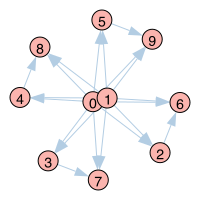

In [3]:
# Create simple network with 0 and 1 as the influential nodes
source = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3,4,5]
target = [2,3,4,5,6,7,8,9,2,3,4,5,6,7,8,9,6,7,8,9]

# Create dataframe representation
d = pd.DataFrame({'source':source,'target':target})

# Create igraph representation for plotting
gr = Graph(directed=True)
gr.add_vertices(range(10))
gr.add_edges(zip(source,target))

# Plot graph
gr.vs["label"], gr.es["color"], gr.vs["color"] = range(10), "#B3CDE3", "#FBB4AE"
plot(gr,bbox = (200, 200), margin = 20,layout = gr.layout("kk"))

Running each of the algorithms on this graph to find the most influential seed set of size $k=2$ successfully obtains the two nodes (the choice of `p` and `mc` doesn't really matter here).

In [9]:
# Run algorithms
ris_output  = ris(d,2,p=0.5,mc=1000)
celf_output = celf(d,2,p=0.5,mc=1000)

# Print resulting seed set
print("RIS seed set:  %s" %ris_output[0])
print("CELF seed set: %s" %celf_output[0])

RIS seed set:  [0, 1]
CELF seed set: [0, 1]


## Example 2: A Larger Network

We now step away from our toy example to consider a larger arbitrary 100-node network. Instead of directly specifying the network like above, we'll use the `Barabasi` method from the `igraph` package to automatically construct a network created through the Albert-Barabasi [preferential attachment](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model) method which approximates a scale-free network. The exact type of graph doesn't matter as the main points hold for any graph. We convert the network into our dataframe representation by looping over each edge and extracting the source and target nodes. Plotting the network shows that we're now dealing with a larger more complicated graph in which the influential nodes are not obvious.

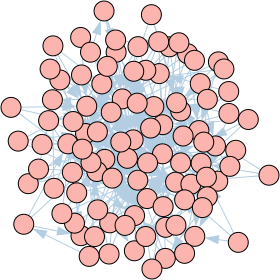

In [6]:
# Generate Graph
G = Graph.Barabasi(n=100, m=3,directed=True)

# Transform into dataframe of edges
source_nodes = [edge.source for edge in G.es]
target_nodes = [edge.target for edge in G.es]
df = pd.DataFrame({'source': source_nodes,'target': target_nodes})

# Plot graph
G.es["color"], G.vs["color"] = "#B3CDE3", "#FBB4AE"
plot(G,bbox = (280, 280),margin = 11,layout=G.layout("kk"))

Unlike the comparison of the Greedy and CELF algorithms in the [previous post](http://hautahi.com/im_greedycelf), and unlike the results from our toy example above, there is no theoretical guarantee that the CELF and RIS approaches should yield identical results for a finite number of Monte Carlo simulations/RRS sets. The only guarantee is that both algorithms yield a seed set that achieves a spread within $(1-1/e-\epsilon)$ of the optimal achievable spread with a given probability, but those sets may be different.

It is worth taking the time here to discuss the difference between the `mc` parameter in each method, and how they relate to the error term $\epsilon$ in the approximation. In CELF, `mc` specifies how many different propagation cascades are run to calculate the mean spread of *each node* under consideration. In RIS, `mc` instead dictates the size of the collection of RRS sets `R`. Setting the same value of `mc` for each method will not usually achieve the same level of accuracy $\epsilon$.

So to make a fair comparison, we ideally want to set the respective values of `mc` in each method such that they both achieve the same $\epsilon$. This, however, is easier said than done. In fact, until recently, the literature simply followed Kempe et al.'s (2003) lead and set `mc=10,000` without really understanding the relationship between `mc` and $\epsilon$ in the CELF or Greedy algorithms. It wasn't until [Tang et al. (2014)](https://arxiv.org/pdf/1404.0900.pdf) that we were finally provided with an explicit statement of the relationship, which is expressed as follows. CELF returns an approximation error of $\epsilon$ with probability at least $1-n^{-1}$ if `mc` is set greater than

$$
(8k^2+2k\epsilon)\cdot n\cdot \frac{(l+1)\log n+\log k}{\epsilon^2\cdot OPT}
$$

where $OPT$ is the maximum achievable spread. The equivalent expression for the RIS algorithms is

$$(8+2\epsilon)\cdot n\cdot \frac{l\log n+\log {n\choose k}+\log 2}{\epsilon^2\cdot OPT}$$

Now the trouble with these expressions is that $OPT$ is generally unknown (because we need to know the thing we're solving for in order to compute it!). So in practice, the literature attempts to come up with a lower bound for $OPT$, which in turn implies an upper bound for the expression above and therefore a conservative estimate on what to set `mc` in order to achieve a given $\epsilon$. A super conservative estimate would we to set $OPT=k$, which effectively assumes that the seed set only activates itself. But this means that we create too many RRS sets or run too many Monte Carlo simulations, so we ideally want a better estimate/tighter lower bound.

But to make things even more tricky, it turns out that figuring out a tighter lower-bound is itself a computationally intensive process so there tends to be a trade-off between wanting to create fewer RRSs and not wanting to waste computational resources figuring out an optimal level of $OPT$ that is required to justify fewer RRSs. Much of the recent literature has been dedicated to exactly this issue (see [Tang et al. (2014)](https://arxiv.org/pdf/1404.0900.pdf), [Tang et al. (2015)](https://dl.acm.org/citation.cfm?id=2723734), [Nguyen et al. (2016)](https://arxiv.org/pdf/1605.07990.pdf),  and [Huang et al. (2017)](https://www.researchgate.net/publication/319600266_Revisiting_the_stop-and-stare_algorithms_for_influence_maximization) among others). We won't get into these complexities in this post, other than to acknowledge that they exist. From here on we'll just set the `mc` values to be large and hope they achieve approximately the same $\epsilon$.

In [27]:
# Run algorithms
celf_output = celf(df,10,p=0.1,mc=10000)
ris_output  = ris(df,10,p=0.1,mc=10000)

The graph below shows a speed comparison of the two algorithms and the relationship between computation time and the size of the seed set. The most obvious point is that the RIS algorithm is much faster (by about an order of magnitude) despite the fact that we used a much larger `mc` value. The other feature of the plot is that the CELF computation time grows somewhat proportionately with the size of the seed set (although not quite, see the previous post to understand why), whereas the RIS algorithm time stays pretty much constant with respect to the size of the seed set. This is because the CELF algorithm must compute the marginal gain for a given potential seed node in each round of the iteration procedure. In contrast, RIS performs all simulations "up front" so that the only cost to expanding the seed set is the "search cost" of finding the node that appears most frequently in a list, which is a relatively cheap computational exercise.

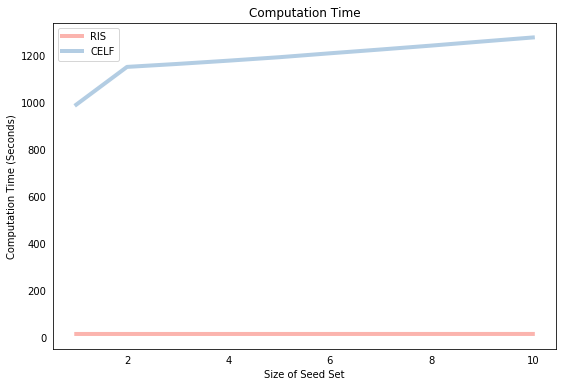

In [28]:
# Plot
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(range(1,len(celf_output[1])+1),ris_output[1],label="RIS",color="#FBB4AE",lw=4)
ax.plot(range(1,len(celf_output[1])+1),celf_output[1],label="CELF",color="#B3CDE3",lw=4)
ax.legend(loc=2)
plt.ylabel('Computation Time (Seconds)')
plt.xlabel('Size of Seed Set')
plt.title('Computation Time')
plt.tick_params(bottom = False, left = False)
plt.show()

As mentioned, the only guarantee is that both approaches will yield solutions that achieve at least $(1-1/e-\epsilon) \approx $ 63%  of the optimal spread, which leaves a significant amount of room for the approaches to produce different solutions. To the best of my knowledge, there hasn't been a systematic comparison of the methods to find which approach achieves a superior spread, empirically, and under which conditions. Below, we first print the resulting seed sets from each method, which differ but show some overlap. We then run each of the seed sets through an IC propagation function, which shows that they also achieve approximately the same spread.

In [29]:
# Print resulting seed set solutions
print("CELF Seed Set: %s" %celf_output[0])
print("RIS Seed Set:  %s" %ris_output[0])

# Compute the spread of each seed set
celf_spread = IC(df,celf_output[0],0.1,mc=10000)
ris_spread  = IC(df,ris_output[0],0.1,mc=10000)

# Print resulting spread
print("\nCELF Spread: %s" %celf_spread)
print("RIS Spread:  %s" %ris_spread)

CELF Seed Set: [22, 28, 41, 69, 70, 75, 81, 82, 91, 93]
RIS Seed Set:  [22, 27, 28, 34, 40, 42, 48, 89, 90, 93]

CELF Spread: 13.328
RIS Spread:  13.3285


In our particular example above, the RIS spread was slightly higher, but this is due to randomness. If we repeated that same analysis the "best" method would change, but would stay around the 13.3 region.

The speed comparison above showed how each algorithm scales with respect to the size of the seed set. We'll conclude by showing how they scale with respect to network size. Below, we solve each algorithm for a selection of different network sizes (with some parameters tweaked to save time) and plot the computation time against the number of nodes in the network. Again, we find that CELF scales approximately linearly with network size whereas RIS is almost indifferent to network size in these small scales.

In [7]:
CELF_TIME, RIS_TIME, SIZES = [], [], [10,50,100,500,750,1000]

for n in SIZES:
    
    # Generate Graph
    G = Graph.Barabasi(n=n,m=3,directed=True)

    # Transform into dataframe of edges
    source_nodes = [edge.source for edge in G.es]
    target_nodes = [edge.target for edge in G.es]
    df = pd.DataFrame({'source': source_nodes,'target': target_nodes})

    # Run algorithms
    celf_output = celf(df,5,p=0.1,mc=1000)
    ris_output  = ris(df,5,p=0.1,mc=1000)
    
    # Store
    CELF_TIME.append(celf_output[1][-1])
    RIS_TIME.append(ris_output[1][-1])

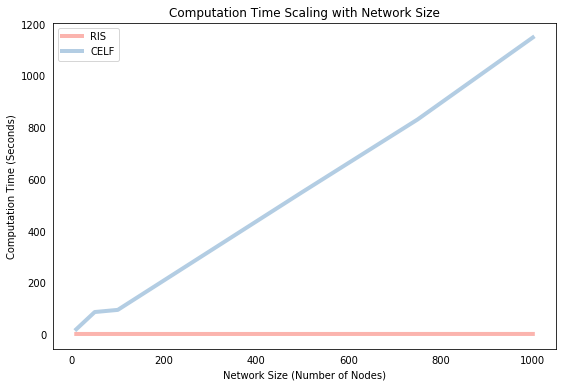

In [10]:
# Plot computation time with respect to network size
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)
ax1.plot(SIZES, RIS_TIME, label="RIS", color="#FBB4AE",lw=4)
ax1.plot(SIZES, CELF_TIME, label="CELF", color="#B3CDE3",lw=4)
ax1.legend(loc=2)
plt.ylabel('Computation Time (Seconds)')
plt.xlabel('Network Size (Number of Nodes)')
plt.title('Computation Time Scaling with Network Size')
plt.tick_params(bottom = False, left = False)
plt.show()

## Conclusion

We implemented both the CELF and RIS algorithms as simple Python functions and showed the following:

- Both algorithms result in similar seed sets and influence spread.
- The RIS algorithm runs a lot faster and scales much better with network size and seed set size.